# Calculate Tajima's D for H5N1 within-host data

September 13, 2019 

We have generated estimates of gene-wise πN and πS values to test for selection across coding regions. To determine whether the excess of low-frequency variation we observe could be due to demographic factors (population expansion), I would also like to calculate Tajima's D. This notebook includes code for manually calculating Tajima's D, using pre-computed genewise estimates of πN and πS (calculated by SNPGenie), and the 1% variant calls used for the rest of the analyses in the manuscript. Details describing the equations used for Tajima's D are shown in the markdown snippets below. 

Tajima's D is a statistic used to summarize a site frequency spectrum, and is calculated as the difference between 2 population genetics estimates of diversity (θ), π and S. π is the average number of pairwise differences between you sequences, divided by sequence length (πN and πS in the SNPGenie output). S is the number of segregating sites, with a correction for the number of individuals being compared. These measurements differ in that S is not affected by the frequency of variants, while π directly takes this into consideration. From wikipedia, the formula for Tajima's D is: 

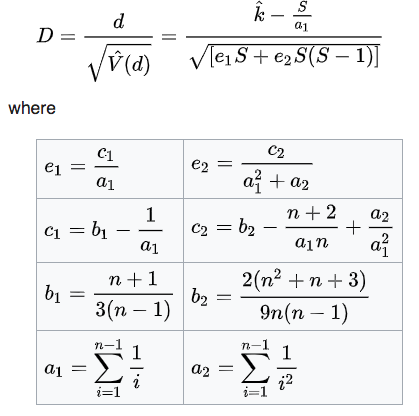

where k-hat is π, a is a correction for the sampled population size, and b,c, and e values are part of the calculation for the variance estimate that forms the denominator for D. For these calculations, I will use the mean coverage across the coding region as the estimate for n (population sample size), or for the full genome estimate, the mean coverage across all coding regions added together.  

In [48]:
# import necessary modules
import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
from subprocess import call
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats


import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [49]:
# define colors 
human_color = "#C75643"
duck_color = "#545AB7"

duck_nonsyn_color = "#545AB7"
duck_syn_color = "#98B4DA"
human_nonsyn_color = "#C75643"
human_syn_color = "#E6B692"

## Functions for reading in and calculating coverage

I am first calculating the mean coverage across each coding region for each sample, which I will then use as my n value (population sample size). 

In [64]:
import os.path
from os import path

"""Because not all samples have the same genome length, and they were not all mapped to the
same reference sequence, I need to define the coding regions separately for each sample.
Reading in the gtf files (which contain coordinates for coding regions) and the pileup
files, calculate the average coverage across each coding region for each sample."""

def define_coding_region(sample_id, gene):
    
    file_to_open = "../data/gtfs/" + sample_id + ".gtf"
    
    if path.exists(file_to_open):
        with open(file_to_open) as infile:
            start = []
            stop = []
            for line in infile: 
                if "CDS" in line and gene in line: 
                    start.append(int(line.split("\t")[3]))
                    stop.append(int(line.split("\t")[4]))
                    gene_id = line.split("\t")[8].split(";")[0].replace("gene_id \"","").replace("\"","")
                    
        return(start,stop)
    
    else: 
        return(0,0)

In [65]:
"""This function will take in a list of pileup files, and then iterate through each file.
Pileup files are organized such that each line corresponds to a single site in the genome, 
and is associated with an overall coverage value, and then the actual nucleotides present
at that site. I have noticed in the past that sometimes if there are 0 coverage sites 
at the beginning or ending of the gene, those sites will be omitted from the pileup file
rather than having a site with a coverage of 0. Because we want to find the total average
coverage across the coding region, we want to count any sites with 0 coverage as a
0. The code at the very end of this function will take care of that. Additionally, for 
sites that lie within multiple coding regions (sites in MP and NS), we need to make sure 
to incorporate those coverage values into coverage calculations for both coding regions. 
We need to do this because I calculated pi independently for each coding region. 
So, in total, this function will read in pileup files, query the coding regions for each 
gene, and output a list with all the sites and their coverages."""

def generate_coverage_values(pileups):
    
    coverages = {}

    for p in pileups: 
        with open(p, "r") as infile: 

            for line in infile: 
                header = line.split("\t")[0]
                sample = "/".join(header.split("_")[1:-1])
                sample_id = "_".join(header.split("_")[1:-1])
                site = int(line.split("\t")[1])
                coverage = int(line.split("\t")[3])
                
                # rename HA and NA, and split out MP and NS into M1/M2 and NS1/NEP 
                gene = "".join(header.split("_")[-1:])
                gene = gene.replace("N1","NA").replace("H5","HA")
                if gene == "MP":
                    genes_to_query = ["M1","M2"]
                elif gene == "NS":
                    genes_to_query = ["NS1","NEP"]
                else: 
                    genes_to_query = [gene]

                for g in genes_to_query:
                    # get the gene coordinates 
                    start,stop = define_coding_region(sample_id, g)
                
                    if sample not in coverages: 
                        coverages[sample] = {}
                    if g not in coverages[sample]:
                        coverages[sample][g] = []
                    if g in coverages[sample]:
                        for i in range(len(start)):
                            if site >= start[i] and site <= stop[i]: 
                                coverages[sample][g].append(coverage)
                        
                        
        # now fill in 0 coverage sites, just in case the pileup file doesn't have that in there
        for gene in coverages[sample]:
            coverage_length = len(coverages[sample][gene])
            start,stop = define_coding_region(sample_id, gene)
            cds_length = 0 
            for i in range(len(start)):
                cds_length += int(stop[i]) - int(start[i]) + 1
                
            difference = cds_length - coverage_length
            for i in range(difference):
                coverages[sample][gene].append(0)

    return(coverages)

In [66]:
"""Given a dictionary of samples with coverage lists, take the mean coverage per coding
region and per full genome."""

def return_coverage_means(coverages):
    coverage_means = {}
    
    for sample in coverages:
        coverage_means[sample] = {}
        full_genome_coverages = 0
        full_genome_length = 0
        
        # calculate for each gene
        for gene in coverages[sample]:            
            if len(coverages[sample][gene]) > 0:
                mean = float(sum(coverages[sample][gene]))/len(coverages[sample][gene])
                full_genome_coverages += sum(coverages[sample][gene])
                full_genome_length += len(coverages[sample][gene])
            else:
                mean = 0

            coverage_means[sample][gene] = mean
        
        # calculate for full genome
        full_genome_mean = full_genome_coverages/full_genome_length
        coverage_means[sample]['full\ngenome'] = full_genome_mean
            
    return(coverage_means)

In [67]:
def generate_coverage_means_dataframe(coverage_means):
    df = pd.DataFrame.from_dict(coverage_means, orient="columns")
    return(df)

## Functions for generating correction for coverage, a1, and other values necessary for variance calculation

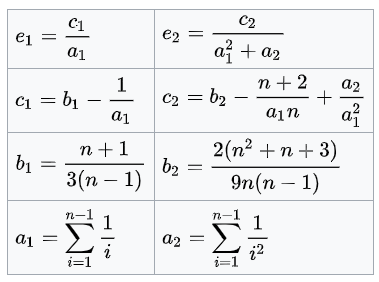

In [68]:
def calculate_a_values(mean_coverage):
    a1 = 0
    a2 = 0
    integer_value = round(mean_coverage)
    for i in range(1, integer_value):
        a1 += 1/i
        a2 += 1/(i**2)
    return(a1,a2)

In [69]:
def calculate_b_values(mean_coverage):
    integer_value = round(mean_coverage)
    b1 = (integer_value + 1)/(3*(integer_value - 1))
    b2 = (2*(integer_value**2 + integer_value + 3))/((9*integer_value)*(integer_value - 1))
    return(b1,b2)

In [70]:
def calculate_c_values(mean_coverage,a1,a2,b1,b2):
    integer_value = round(mean_coverage)
    c1 = b1 - (1/a1)
    c2 = b2 - ((integer_value + 2)/(a1*integer_value)) + (a2/(a1**2))
    return(c1,c2)

In [71]:
def calculate_e_values(a1,a2,c1,c2):
    e1 = c1/a1
    e2 = c2/((a1**2)+a2)
    return(e1,e2)

In [72]:
def return_all_corrections_values(mean_coverage):
    a1,a2 = calculate_a_values(mean_coverage)
    b1,b2 = calculate_b_values(mean_coverage)
    c1,c2 = calculate_c_values(mean_coverage,a1,a2,b1,b2)
    e1,e2 = calculate_e_values(a1,a2,c1,c2)
    
    return(a1,a2,b1,b2,c1,c2,e1,e2)

In [73]:
def generate_a_values_dict_and_df(coverage_means):
    a_values = {}

    for sample in coverage_means: 
        a_values[sample] = {}
        for gene in coverage_means[sample]:
            mean_coverage = float(coverage_means[sample][gene])
            a1,a2 = calculate_a_values(mean_coverage)
            a_values[sample][gene] = a1
            

    a_values_df = pd.DataFrame.from_dict(a_values, orient="index")
    a_values_df.reset_index(inplace=True)
    
    a_values_df2 = pd.melt(a_values_df, id_vars="index")
    a_values_df2.columns = ['sample',"gene","a_correction"]
    
    return(a_values, a_values_df, a_values_df2)

In [74]:
def generate_e_values_dict_and_df(coverage_means):
    e1_values = {}
    e2_values = {}

    for sample in coverage_means: 
        e1_values[sample] = {}
        e2_values[sample] = {}
        
        for gene in coverage_means[sample]:
            mean_coverage = float(coverage_means[sample][gene])
            if int(mean_coverage) > 0:
                a1,a2,b1,b2,c1,c2,e1,e2 = return_all_corrections_values(mean_coverage)
                e1_values[sample][gene] = e1
                e2_values[sample][gene] = e2
            else:
                e1_values[sample][gene] = 0
                e1_values[sample][gene] = 2

    e1_values_df = pd.DataFrame.from_dict(e1_values, orient="index")
    e2_values_df = pd.DataFrame.from_dict(e2_values, orient="index")
    e1_values_df.reset_index(inplace=True)
    e2_values_df.reset_index(inplace=True)
    
    e1_values_df2 = pd.melt(e1_values_df, id_vars="index")
    e2_values_df2 = pd.melt(e2_values_df, id_vars="index")
    e1_values_df2.columns = ['sample',"gene","e1"]
    e2_values_df2.columns = ['sample',"gene","e2"]
    
    e_values_df2 = e1_values_df2.merge(e2_values_df2, on=['sample','gene'])
    
    return(e_values_df2)

## Functions for reading in and count the number of SNVs per gene, per sample 

In [75]:
def read_and_format_dataframe(snps_df):
    
    # reformat the sampleid 
    snps_df['sampleid'] = snps_df['sampleid'].str[14:]

    # get rid of the incorrect variant call due to a mismatched reference base
    snps_df = snps_df[snps_df['coding_region_change'] != 'Xaa240Gly']

    # change NAs to neuramindase
    snps_df['gene'].fillna('neuraminidase', inplace=True)
    
    return(snps_df)

In [76]:
def generate_SNV_counts_dataframe(snps_df):
    
    # count the number of SNPs per gene per sample and output as a dataframe
    counts = pd.DataFrame(snps_df.groupby(["sample", "gene","synonymous_nonsynonymous"]).size())
    counts.reset_index(inplace=True)
    counts.columns = ['sample','gene','synonymous_nonsynonymous','number_of_SNPs']
    
    # unmelt the synonymous nonsynonymous column
    counts = counts[counts['synonymous_nonsynonymous'] != 'stop_gained']   # remove stop gained
    counts = counts.pivot_table(index = ['sample','gene'], columns = 'synonymous_nonsynonymous', values='number_of_SNPs')
    counts.reset_index(inplace=True)
    counts = counts.fillna(0)
    
    # add in a species column
    counts['species'] = counts['sample'].str.contains("duck")
    counts['species'] = counts['species'].replace(True,"duck")
    counts['species'] = counts['species'].replace(False,"human")
    
    # rename columns
    counts.columns = ["sample","gene","nonsynonymous","synonymous","species"]

    return(counts)

In [77]:
def generate_full_genome_SNV_counts_dataframe(snps_df):
    
    # count the number of SNPs per gene per sample and output as a dataframe
    counts = pd.DataFrame(snps_df.groupby(["sample", "synonymous_nonsynonymous"]).size())
    counts.reset_index(inplace=True)
    counts.columns = ['sample','synonymous_nonsynonymous','number_of_SNPs']
    
    # unmelt the synonymous nonsynonymous column
    counts = counts[counts['synonymous_nonsynonymous'] != 'stop_gained']   # remove stop gained
    counts = counts.pivot_table(index = ['sample'], columns = 'synonymous_nonsynonymous', values='number_of_SNPs')
    counts.reset_index(inplace=True)
    counts = counts.fillna(0)
    
    # add in a species column
    counts['species'] = counts['sample'].str.contains("duck")
    counts['species'] = counts['species'].replace(True,"duck")
    counts['species'] = counts['species'].replace(False,"human")
    
    # add back gene column
    counts['gene'] = "full\ngenome"
    
    # reorder columns
    counts.columns = ["sample","nonsynonymous","synonymous","species","gene"]
    counts = counts[['sample','gene','nonsynonymous','synonymous','species']]

    return(counts)

## Read in coverage data, generate a1 correction and e values

In [78]:
# read in pileup files
pileups = []
for f in glob.glob("../data/pileup-files/*.pileup"):
    pileups.append(f)
print(len(pileups))

13


In [79]:
# generate coverage means 
coverages = generate_coverage_values(pileups)
coverage_means = return_coverage_means(coverages)
coverage_means_df = generate_coverage_means_dataframe(coverage_means)
coverage_means_df.head()

,A/CAMBODIA/V0401301/2011,A/CAMBODIA/V0417301/2011,A/Cambodia/W0112303/2012,A/Cambodia/X0125302/2013,A/Cambodia/X0128304/2013,A/Cambodia/X0207301/2013,A/Cambodia/X0219301/2013,A/Cambodia/X1030304/2013,A/duck/Cambodia/083D1/2011,A/duck/Cambodia/381W11M4/2013,A/duck/Cambodia/PV027D1/2010,A/duck/Cambodia/Y0224301/2014,A/duck/Cambodia/Y0224304/2014
HA,186.628588,175.719977,163.018161,80.453427,234.970709,172.251904,81.374341,274.752783,244.888108,221.918871,220.057996,203.888108,213.377934
M1,328.113134,330.151515,331.674572,361.175231,304.752306,341.894598,331.649539,351.992095,280.586298,263.931489,271.175231,285.595520,311.998682
M2,269.295775,265.197279,260.775510,297.353741,251.809524,263.221088,265.261905,284.755102,267.285714,238.013605,252.047619,245.812925,302.064626
NA,311.654815,306.342222,318.037037,323.909630,301.157778,318.800741,322.184444,300.191852,275.793333,213.525926,222.408148,272.128889,242.591852
NEP,248.762295,251.079235,245.587432,287.174863,287.046448,223.734973,236.669399,293.016393,266.797814,232.579235,220.448087,262.120219,310.352459


In [57]:
a_values,a_values_df,a_values_df2 = generate_a_values_dict_and_df(coverage_means)
a_values_df.head()

,index,HA,M1,M2,NA,NP,NS1,NEP,PA,PB1,PB2,full genome
0,A/CAMBODIA/V0401301/2011,5.805648,6.368704,6.170067,6.318615,6.315400,6.302434,6.092659,6.275986,6.248820,6.013119,6.188518
1,A/CAMBODIA/V0417301/2011,5.744856,6.374792,6.155058,6.299166,6.365646,6.302434,6.100675,6.401740,6.337694,6.234955,6.262495
2,A/Cambodia/W0112303/2012,5.667895,6.380844,6.139819,6.337694,6.350214,6.272630,6.080513,6.383856,6.305691,6.147467,6.231458
3,A/Cambodia/X0125302/2013,4.952979,6.464708,6.269263,6.356415,6.334539,6.401740,6.234955,6.334539,6.234955,6.021796,6.173785
4,A/Cambodia/X0128304/2013,6.034672,6.295887,6.104659,6.282664,6.181178,6.325015,6.234955,6.076432,NaN,6.096675,6.155058


In [80]:
a_values_df2.head()

,sample,gene,a_correction
0,A/CAMBODIA/V0401301/2011,HA,5.805648
1,A/CAMBODIA/V0417301/2011,HA,5.744856
2,A/Cambodia/W0112303/2012,HA,5.667895
3,A/Cambodia/X0125302/2013,HA,4.952979
4,A/Cambodia/X0128304/2013,HA,6.034672


In [81]:
e_values_df2 = generate_e_values_dict_and_df(coverage_means)
e_values_df2.head()

,sample,gene,e1,e2
0,A/CAMBODIA/V0401301/2011,HA,0.028364,0.002806
1,A/CAMBODIA/V0417301/2011,HA,0.028386,0.002841
2,A/Cambodia/W0112303/2012,HA,0.028408,0.002885
3,A/Cambodia/X0125302/2013,HA,0.028240,0.003346
4,A/Cambodia/X0128304/2013,HA,0.028249,0.002682


In [82]:
# merge a, e1, and e2 values together into 1 dataframe that can be combined with the pi and S data
corrections_df = a_values_df2.merge(e_values_df2, on=['sample','gene'])
corrections_df['gene'] = corrections_df['gene'].str.replace("NA","neuraminidase")
corrections_df.head()

,sample,gene,a_correction,e1,e2
0,A/CAMBODIA/V0401301/2011,HA,5.805648,0.028364,0.002806
1,A/CAMBODIA/V0417301/2011,HA,5.744856,0.028386,0.002841
2,A/Cambodia/W0112303/2012,HA,5.667895,0.028408,0.002885
3,A/Cambodia/X0125302/2013,HA,4.952979,0.028240,0.003346
4,A/Cambodia/X0128304/2013,HA,6.034672,0.028249,0.002682


## Read in within-host variant calls 

In [83]:
# variant calls file to load in
variant_calls = "../data/within-host-variants-1%.tsv"

snps_df = pd.read_csv(variant_calls, sep='\t', header='infer')

snps_df = read_and_format_dataframe(snps_df)
snv_counts_df = generate_SNV_counts_dataframe(snps_df)
snv_counts_full_genome_df = generate_full_genome_SNV_counts_dataframe(snps_df)

snv_counts_df = snv_counts_df.append(snv_counts_full_genome_df)
snv_counts_df.head()

,sample,gene,nonsynonymous,synonymous,species
0,A/CAMBODIA/V0401301/2011,HA,12.0,1.0,human
1,A/CAMBODIA/V0401301/2011,M1,1.0,0.0,human
2,A/CAMBODIA/V0401301/2011,NP,4.0,2.0,human
3,A/CAMBODIA/V0401301/2011,PA,8.0,1.0,human
4,A/CAMBODIA/V0401301/2011,PB1,4.0,4.0,human


## Merge together and calculate S with a1 correction (S/a1) and variance

In [84]:
# add in a column for the correction factor 
snv_counts_with_correction_df = snv_counts_df.merge(corrections_df, how="left")
snv_counts_with_correction_df['S/a1_NS'] = snv_counts_with_correction_df['nonsynonymous']/snv_counts_with_correction_df['a_correction']
snv_counts_with_correction_df['S/a1_S'] = snv_counts_with_correction_df['synonymous']/snv_counts_with_correction_df['a_correction'] 
snv_counts_with_correction_df.head()

,sample,gene,nonsynonymous,synonymous,species,a_correction,e1,e2,S/a1_NS,S/a1_S
0,A/CAMBODIA/V0401301/2011,HA,12.0,1.0,human,5.805648,0.028364,0.002806,2.066953,0.172246
1,A/CAMBODIA/V0401301/2011,M1,1.0,0.0,human,6.368704,0.028005,0.002514,0.157018,0.000000
2,A/CAMBODIA/V0401301/2011,NP,4.0,2.0,human,6.315400,0.028049,0.002540,0.633372,0.316686
3,A/CAMBODIA/V0401301/2011,PA,8.0,1.0,human,6.275986,0.028081,0.002559,1.274700,0.159338
4,A/CAMBODIA/V0401301/2011,PB1,4.0,4.0,human,6.248820,0.028102,0.002572,0.640121,0.640121


### Calculate variance 

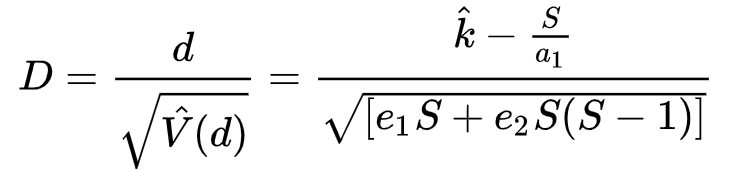

In [85]:
# add in variance
snv_counts_with_correction_df["variance_NS"] = np.sqrt((snv_counts_with_correction_df["e1"] * snv_counts_with_correction_df['nonsynonymous'])+(snv_counts_with_correction_df["e2"]*snv_counts_with_correction_df['nonsynonymous']*(snv_counts_with_correction_df['nonsynonymous']-1)))
snv_counts_with_correction_df["variance_S"] = np.sqrt((snv_counts_with_correction_df["e1"] * snv_counts_with_correction_df['synonymous'])+(snv_counts_with_correction_df["e2"]*snv_counts_with_correction_df['synonymous']*(snv_counts_with_correction_df['synonymous']-1)))

snv_counts_with_correction_df.head()

,sample,gene,nonsynonymous,synonymous,species,a_correction,e1,e2,S/a1_NS,S/a1_S,variance_NS,variance_S
0,A/CAMBODIA/V0401301/2011,HA,12.0,1.0,human,5.805648,0.028364,0.002806,2.066953,0.172246,0.843084,0.168416
1,A/CAMBODIA/V0401301/2011,M1,1.0,0.0,human,6.368704,0.028005,0.002514,0.157018,0.000000,0.167346,0.000000
2,A/CAMBODIA/V0401301/2011,NP,4.0,2.0,human,6.315400,0.028049,0.002540,0.633372,0.316686,0.377720,0.247341
3,A/CAMBODIA/V0401301/2011,PA,8.0,1.0,human,6.275986,0.028081,0.002559,1.274700,0.159338,0.606588,0.167572
4,A/CAMBODIA/V0401301/2011,PB1,4.0,4.0,human,6.248820,0.028102,0.002572,0.640121,0.640121,0.378518,0.378518


## Read in π values and generate full genome N sites and S sites

For all samples, regardless of whether there were variants present or not, we need to know the number of synonymous and nonsynonymous sites. Unfortunately, SNPGenie will not calculate pi values of 0 or run for samples and genes with no variants called. So that I could still get the program to calculate the number of nonsynonymous and synonymous sites, I generated dummy data with a single called variant and used that as the input for all of the samples and genes that did not have any variants called. I then replaced all calculated pi values with 0 and retained only the data on the number of synonymous and nonsynonymous sites. This dataset was appended to the calculated pi data from samples with SNVs into 1, combined data file, "pi-values.tsv", which will be read in here. 

In [92]:
# read in pi data as a dataframe
pi_data = pd.read_table("../data/pi-values.tsv", sep="\t")
pi_data['product'] = pi_data['product'].fillna('neuram')                                     # replace NA with neuram
pi_data['species'] = np.where((pi_data['file'].str.contains("duck")), "duck","human")        # add in a species column
pi_data = pi_data.drop(["N_diffs","S_diffs","N_diffs_vs_ref","S_diffs_vs_ref","mean_dN_vs_ref","mean_dS_vs_ref","mean_gdiv_polymorphic","mean_N_gdiv","mean_S_gdiv"], axis=1)

pi_data['sample'] = pi_data['file'].str.split("_").str[1:].str.join("/")
pi_data = pi_data.drop("file", axis=1)
pi_data.columns = ['gene',"N_sites","S_sites","piN","piS","species","sample"]
pi_data['gene'] = pi_data['gene'].str.replace("neuram","neuraminidase")
pi_data.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,gene,N_sites,S_sites,piN,piS,species,sample
0,HA,1332.740397,370.650907,0.001326,0.000603,human,A/Cambodia/X0128304/2013
1,M1,578.515594,177.484406,0.000606,0.001177,human,A/Cambodia/X0128304/2013
2,M2,227.000000,64.000000,0.000421,0.000000,human,A/Cambodia/X0128304/2013
3,neuraminidase,1050.119423,296.880577,0.000131,0.000727,human,A/Cambodia/X0128304/2013
4,NEP,286.009964,76.990036,0.000203,0.000000,human,A/Cambodia/X0128304/2013


In [93]:
def generate_full_genomes_pi_dataframe(df):
    
    gene_proportions_dict = {"PB2":0.172, "PB1":0.170,"PA":0.161, "HA":0.128,"NP":0.113,
                        "neuraminidase":0.101,"M1":"0.057","M2":0.022,"NS1":0.049,"NEP":0.027}
    
    full_genomes_df = pd.DataFrame()

    for sample in set(df['sample'].tolist()):

        full_genome_piN = 0
        full_genome_piS = 0
        
        for gene in set(df['gene'].tolist()):
            local_df = df[(df['sample'] == sample) & (df['gene'] == gene)]

            if sample == 'A/Cambodia/X0128304/2013' and gene == 'PB1':
                pass

            else:
                species = local_df['species'].item()
                gene_piN = float(local_df['piN'])
                gene_piS = float(local_df['piS'])

            weight = float(gene_proportions_dict[gene])

            full_genome_piN += (gene_piN * weight)
            full_genome_piS += (gene_piS * weight)

        to_add_df = pd.DataFrame.from_dict({"sample":[sample],"gene":['full\ngenome'],
                                            "piN":[full_genome_piN],"piS":[full_genome_piS],
                                            "species":[species]})

        full_genomes_df = full_genomes_df.append(to_add_df)
    return(full_genomes_df)

In [94]:
# add in N_sites and S_sites for full genomes 
def pull_out_full_genome_sites(df):
    to_add_df = pd.DataFrame()
    
    for s in set(df['sample'].tolist()):
        d = df[df['sample'] == s]
        N_sites_total = d['N_sites'].sum()
        S_sites_total = d['S_sites'].sum()
        
        to_add = pd.DataFrame.from_dict({"gene":["full\ngenome"],"N_sites":[N_sites_total],
                                        "S_sites":[S_sites_total],"sample":[s]})
        
        to_add_df = to_add_df.append(to_add)
    return(to_add_df)

In [95]:
# run to generate and then can append to the pi dataframe
full_genome_pi = generate_full_genomes_pi_dataframe(pi_data)
full_genome_sites = pull_out_full_genome_sites(pi_data)
full_genome = full_genome_pi.merge(full_genome_sites, on=['sample','gene'])

# reorder columns
full_genome = full_genome[['gene','N_sites',"S_sites",'piN','piS','species','sample']]
full_genome

,gene,N_sites,S_sites,piN,piS,species,sample
0,full\ngenome,10345.092060,2977.907939,0.000009,0.000061,duck,A/duck/Cambodia/PV027D1/2010
1,full\ngenome,10338.623038,2984.376961,0.000064,0.000586,human,A/Cambodia/X0207301/2013
2,full\ngenome,10349.065751,2976.934249,0.000114,0.000442,human,A/CAMBODIA/V0417301/2011
3,full\ngenome,10340.460795,2985.539205,0.000013,0.000102,duck,A/duck/Cambodia/Y0224301/2014
4,full\ngenome,10355.909701,2970.090299,0.000073,0.000317,human,A/Cambodia/W0112303/2012
5,full\ngenome,10340.778734,2985.221265,0.000038,0.000123,human,A/Cambodia/X1030304/2013
6,full\ngenome,10295.688257,2964.070248,0.000298,0.000461,human,A/CAMBODIA/V0401301/2011
7,full\ngenome,8574.392338,2479.998967,0.000375,0.000786,human,A/Cambodia/X0128304/2013
8,full\ngenome,10341.318937,2984.681063,0.000017,0.000100,human,A/Cambodia/X0219301/2013
9,full\ngenome,10332.809799,2987.190200,0.000035,0.000333,duck,A/duck/Cambodia/Y0224304/2014


#### Append full genome pi data to pi dataframe

In [96]:
pi_data = pi_data.append(full_genome)
pi_data.head()

,gene,N_sites,S_sites,piN,piS,species,sample
0,HA,1332.740397,370.650907,0.001326,0.000603,human,A/Cambodia/X0128304/2013
1,M1,578.515594,177.484406,0.000606,0.001177,human,A/Cambodia/X0128304/2013
2,M2,227.000000,64.000000,0.000421,0.000000,human,A/Cambodia/X0128304/2013
3,neuraminidase,1050.119423,296.880577,0.000131,0.000727,human,A/Cambodia/X0128304/2013
4,NEP,286.009964,76.990036,0.000203,0.000000,human,A/Cambodia/X0128304/2013


## Merge S with π values, calculate Tajima's D

In [97]:
# merge to generate Tajima's D dataframe
Tajimas_D = snv_counts_with_correction_df.merge(pi_data, on=['gene','sample','species'], how="left")

# alternatively, try multiplying piN and piS by the length 
Tajimas_D['piN*L'] = Tajimas_D['piN']*Tajimas_D['N_sites']
Tajimas_D['piS*L'] = Tajimas_D['piS']*Tajimas_D['S_sites']

# subtract S/a1 from pi corrected for length and divide by variance to get D!
Tajimas_D['D_NS'] = (Tajimas_D['piN*L'] - Tajimas_D['S/a1_NS'])/Tajimas_D['variance_NS']
Tajimas_D['D_S'] = (Tajimas_D['piS*L'] - Tajimas_D['S/a1_S'])/Tajimas_D['variance_S']

Tajimas_D.head()

,sample,gene,nonsynonymous,synonymous,species,a_correction,e1,e2,S/a1_NS,S/a1_S,variance_NS,variance_S,N_sites,S_sites,piN,piS,piN*L,piS*L,D_NS,D_S
0,A/CAMBODIA/V0401301/2011,HA,12.0,1.0,human,5.805648,0.028364,0.002806,2.066953,0.172246,0.843084,0.168416,1332.953494,371.046506,0.000904,0.000173,1.205294,0.064076,-1.022031,-0.642277
1,A/CAMBODIA/V0401301/2011,M1,1.0,0.0,human,6.368704,0.028005,0.002514,0.157018,0.000000,0.167346,0.000000,544.666667,166.333333,0.000000,0.000000,0.000000,0.000000,-0.938281,NaN
2,A/CAMBODIA/V0401301/2011,NP,4.0,2.0,human,6.315400,0.028049,0.002540,0.633372,0.316686,0.377720,0.247341,1148.016471,345.983529,0.000189,0.000295,0.216629,0.102099,-1.103313,-0.867576
3,A/CAMBODIA/V0401301/2011,PA,8.0,1.0,human,6.275986,0.028081,0.002559,1.274700,0.159338,0.606588,0.167572,1684.400174,463.421018,0.000365,0.000193,0.614640,0.089373,-1.088153,-0.417521
4,A/CAMBODIA/V0401301/2011,PB1,4.0,4.0,human,6.248820,0.028102,0.002572,0.640121,0.640121,0.378518,0.378518,1767.926824,503.073176,0.000311,0.000866,0.550003,0.435834,-0.238081,-0.539702


### Calculate the mean Tajima's D for each gene and host species for plotting

In [98]:
def generate_mean_D_dataframes_for_plotting(dataframe):
    D_df = dataframe[["sample",'gene','D_NS',"D_S","species"]]
    D_df = D_df.pivot(index='sample',columns='gene',values=['D_NS','D_S'])
    D_df = D_df.fillna(0)
    D_df.loc['mean'] = D_df.mean()
    D_df.loc['stdev'] = D_df.std()
    
    D_means = D_df.iloc[[-2]]
    D_means2 = pd.melt(D_means)
    D_means2.columns = ['value','gene','mean_Tajimas_D']
    
    D_std = D_df.iloc[[-1]]
    D_std2 = pd.melt(D_std)
    D_std2.columns = ['value','gene','std_Tajimas_D']
    
    D_df = D_means2.merge(D_std2, on=['value','gene'])
    
    return(D_df)

In [99]:
# split into human and duck
human_D = Tajimas_D[Tajimas_D['species'] == 'human']
duck_D = Tajimas_D[Tajimas_D['species'] == 'duck']

human_D_df = generate_mean_D_dataframes_for_plotting(human_D)
duck_D_df = generate_mean_D_dataframes_for_plotting(duck_D)

In [100]:
human_D_df['species'] = "human"
duck_D_df['species'] = "duck"

Tajimas_D_means_df = human_D_df.append(duck_D_df)
Tajimas_D_means_df['color'] = Tajimas_D_means_df['species'] + ' ' + Tajimas_D_means_df['value']
Tajimas_D_means_df.head()

,value,gene,mean_Tajimas_D,std_Tajimas_D,species,color
0,D_NS,HA,0.171471,0.713322,human,human D_NS
1,D_NS,M1,-0.391291,0.419104,human,human D_NS
2,D_NS,M2,-0.314994,0.345058,human,human D_NS
3,D_NS,NEP,-0.135062,0.236500,human,human D_NS
4,D_NS,NP,-0.486930,0.502003,human,human D_NS


## Bootstrap Tajima's D estimates

In [101]:
def fill_in_missing_values(D_values,sampling_value):
    D_values = list(np.nan_to_num(D_values))
    missing_values = sampling_value - len(D_values)
    for i in range(missing_values):
        D_values.append(0.0)
    return(D_values)

In [102]:
def bootrap_D_values(D_values, iterations, sampling_value):
    bootstrapped_means = []
    
    for i in range(iterations):
        sample = np.random.choice(D_values, sampling_value, replace=True)
        mean = np.asarray(sample).mean()
        bootstrapped_means.append(mean)
    
    bootstrapped_means_array = np.array(bootstrapped_means)
    a = np.quantile(bootstrapped_means_array, 0.975)
    b = np.quantile(bootstrapped_means_array, 0.025)
    c = np.std(bootstrapped_means_array)
    
    return(a,b,c)

In [103]:
# reformat dataframe for bootstrapping
D_bootstrap_df = Tajimas_D[["sample",'gene','D_NS',"D_S","species"]]
D_bootstrap_df.head()

,sample,gene,D_NS,D_S,species
0,A/CAMBODIA/V0401301/2011,HA,-1.022031,-0.642277,human
1,A/CAMBODIA/V0401301/2011,M1,-0.938281,NaN,human
2,A/CAMBODIA/V0401301/2011,NP,-1.103313,-0.867576,human
3,A/CAMBODIA/V0401301/2011,PA,-1.088153,-0.417521,human
4,A/CAMBODIA/V0401301/2011,PB1,-0.238081,-0.539702,human


In [104]:
iterations = 10000
sampling_values = {"human":8, "duck":5}
df2 = pd.DataFrame()

for species in set(D_bootstrap_df['species'].tolist()):
    
    for gene in set(D_bootstrap_df['gene'].tolist()):
        for D in ["D_NS","D_S"]:
            # add in exception for PB1, since we are missing 1 PB1 sequence 
            if gene == "PB1" and species == "human":
                sampling_value = 7
            else: 
                sampling_value = sampling_values[species]
            
            d = D_bootstrap_df[(D_bootstrap_df['gene'] == gene) & (D_bootstrap_df['species'] == species)]
            values = d[D].tolist()
            
            D_values = fill_in_missing_values(values,sampling_value)
            mean = np.asarray(D_values).mean()
            a,b,c = bootrap_D_values(D_values, iterations, sampling_value)
            
            # generate dataframe 
            x = pd.DataFrame({"species":[species],"gene":[gene],"variable":[D],"mean":[mean],
                            "bootstrap_lower":[b],"bootstrap_upper":[a],"se_mean":[c]})
            df2 = df2.append(x)

In [105]:
df2.head()

,species,gene,variable,mean,bootstrap_lower,bootstrap_upper,se_mean
0,duck,NEP,D_NS,-0.141989,-0.425968,0.0,0.127656
0,duck,NEP,D_S,-0.134578,-0.403733,0.0,0.119849
0,duck,PB1,D_NS,-0.098073,-0.294219,0.0,0.088401
0,duck,PB1,D_S,-0.293501,-0.626830,0.0,0.164183
0,duck,NS1,D_NS,-0.183274,-0.549822,0.0,0.163626


In [106]:
"""These results are the basis for the data plotted in Figure 2c"""
df2['color'] = df2['species'] + " " + df2['variable']
df2

,species,gene,variable,mean,bootstrap_lower,bootstrap_upper,se_mean,color
0,duck,NEP,D_NS,-0.141989,-0.425968,0.000000,0.127656,duck D_NS
0,duck,NEP,D_S,-0.134578,-0.403733,0.000000,0.119849,duck D_S
0,duck,PB1,D_NS,-0.098073,-0.294219,0.000000,0.088401,duck D_NS
0,duck,PB1,D_S,-0.293501,-0.626830,0.000000,0.164183,duck D_S
0,duck,NS1,D_NS,-0.183274,-0.549822,0.000000,0.163626,duck D_NS
0,duck,NS1,D_S,0.000000,0.000000,0.000000,0.000000,duck D_S
0,duck,M1,D_NS,-0.149963,-0.327676,0.000000,0.083918,duck D_NS
0,duck,M1,D_S,0.000000,0.000000,0.000000,0.000000,duck D_S
0,duck,PA,D_NS,0.169457,0.000000,0.508371,0.149629,duck D_NS
0,duck,PA,D_S,-0.280704,-0.527489,-0.033920,0.125845,duck D_S


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


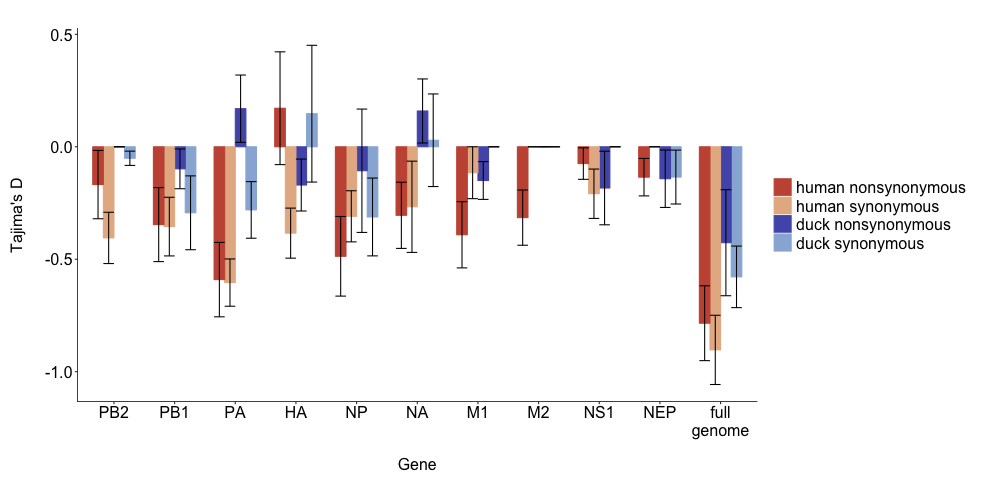

In [107]:
%%R -w 1000 -h 500 -u px -i  df2,human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)


# this block of code is to ensure that even genes without SNPs get plotted so that the bars are all the same size
species_list = unique(df2$species)
gene_list = unique(df2$gene)
variables_list = unique(df2$value)

for (species in species_list)
{
    for (gene in gene_list)
    {
        for (variable in variables_list)
        {
            x = df2[df2$species == species & df2$gene == gene & df2$value == variable,]
            if (nrow(x) == 0){
                mean = 0
                std = 0
                if (variable == "D_NS"){
                    color = paste(species, " D_NS")
                } else{
                    color = paste(species, " D_S")
                }
                row_to_append = data.frame(gene, species, variable, mean, std, color)
                d = rbind(df, row_to_append)
            }
        }
    }
}

df2$gene = gsub("neuraminidase","NA", df2$gene)
df2$colorf = factor(df2$color, levels=c("human D_NS","human D_S","duck D_NS","duck D_S"))
df2$genef = factor(df2$gene, levels=c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP','full\ngenome'))

p2 <- ggplot(data=df2, aes(x=genef, y=mean, color=colorf, fill=colorf, width=0.7)) +
    geom_col(position="dodge")+   
    geom_errorbar(data=df2, aes(x=genef, ymin=mean-se_mean, ymax=mean+se_mean), position="dodge", color="black")+
    labs(x="\nGene",y="Tajima's D")+
    scale_color_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human D_NS","human D_S","duck D_NS","duck D_S"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    scale_fill_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human D_NS","human D_S","duck D_NS","duck D_S"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    #ggtitle("random tables simulation") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #facet_wrap(~genef, scales="free")+
    #scale_y_continuous(limits=c(-0.0012,0.0012))+
    theme(strip.text = element_text(size=16))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.65, "cm"))+
    #theme(legend.key=element_rect(fill=NA,size = 2))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2